## Key indicators as leading and lagging predictors
The first of these algorithms is a general exploration into how certain key variables perform for stock market movements as leading and lagging predictors across various time series. These indicators include:
- The The Volatility Index (VIX)
- Index moving averages (50, 100 and 200 days)
- Treasury rates (5, 10, 30)
- Relative Strength Index
- Put/Call Ratio

In [1]:
#import all libraries needed for analysis and investment metadata
import yfinance as yf
import pandas_datareader as pdr
import alpha_vantage as av
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import visuals as vs

%matplotlib inline

## Further cleanup/data enhancements
### Categorical Field Additions
- Binary above or below SMAs
- General 30 day trend for rates (all)
- Flag for if rates are inverted
- 7 and 30 day trend for VXX

## Prepare DataFrames for Analysis
### Two separate tables
- Discrete variables (1s and 0s)
- Continuous variables
- Add columns for 1, 3, 5, 7, 15, 30, 60, 90 day performance

## Main Functions
Puts all of the above steps together for a seamless execution and returns the two cleaned data frames

In [2]:
def rates():
    """
    Separate function created for pulling in the rates from the alphavantage api

    Inputs: None
    Outputs: df_rate - dataframe that has all of the rates (2,10,30 year) going back as far as the data is available
    
    """
    #years to pull in historic treasury rates for
    years = [2, 10, 30]

    df_rate = pd.DataFrame()

    #set up date column
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=ALUI1VJSESQR07TD'
    r = requests.get(url)
    data = r.json()

    for i in data['data']:
        df_rate = df_rate.append({'date': i['date']}, ignore_index=True)

    #extract historic treasury rates reported daily
    for year in years:
        url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity='+str(year)+'year&apikey=ALUI1VJSESQR07TD'
        r = requests.get(url)
        data = r.json()

        #populate rate
        for i in data['data']:
            df_rate.loc[df_rate['date'] == i['date'], str(year) +'yr_rate'] = i['value']

    df_rate['date'] = pd.to_datetime(df_rate['date']) 
    
    return df_rate

In [3]:
def data_compilation(symbols):
    """
    Main function that does all of the data pulling, cleanup and aggregation

    Inputs: symbols - stock symbol(s) that you want to identify top leading indicators for
    Outputs: 
        df_discrete - a dataframe with each variable discretized
        df_continuous - a dataframe with each variable as it exists directly from the API in a continuous form
    """
    api_key = 'ALUI1VJSESQR07TD'
    ts = TimeSeries(key=api_key)
    #symbols=['QQQ', 'VXX']

    #date range for filtered_date
    start = '2009-01-30'
    end = datetime.now().strftime('%Y-%m-%d')

    df = pd.DataFrame()

    #pull in daily prices for each symbol
    for sym in symbols:
        data, meta_data = ts.get_daily(symbol=sym, outputsize='full')

        #filter data for the specified date range
        filtered_data = {date: values['4. close'] for date, values in data.items() if start <= date <= end}

        #convert filtered_data into a DF
        sym_df = pd.DataFrame.from_dict(filtered_data, orient='index')
        sym_df.index = pd.to_datetime(sym_df.index)

        #rename the column + use the symbol as the column header
        sym_df = sym_df.rename(columns={0: sym})

        #concatenate the DF for the current symbol to the main DF
        df = pd.concat([df, sym_df], axis=1)

    #calculate moving averages
    sma = [50, 100, 200]

    df_sma = df.sort_index(ascending=True) #make ascending to calc SMAs

    #at each sma value, calculate the corresponding sma for each ticker
    for num in sma:
        for sym in symbols:
            col_name = f'{sym}_SMA_{num}' #pass through column name for each sma
            df_sma[col_name] = df_sma[sym].rolling(window=num).mean()

    df_sma = df_sma.sort_index(ascending=False)
    
    #remove rows with NaN
    df_sma_clean = df_sma.dropna()
    df_sma_clean = df_sma_clean.reset_index()
    df_sma_clean = df_sma_clean.rename(columns={'index': 'date'})
    df_sma_clean['date'] = pd.to_datetime(df_sma_clean['date'])
    
    #run rates function
    df_rate = rates()
    
    #Pull in Relative Strength Index
    symbol = symbols[0]

    #set up date column
    url = 'https://www.alphavantage.co/query?function=RSI&symbol='+symbol+'&interval=daily&time_period=10&series_type=open&apikey='+api_key
    rsi_resp = requests.get(url)
    rsi = json.loads(rsi_resp.content)

    rsi_data = rsi['Technical Analysis: RSI']

    df_rsi = pd.DataFrame([(date, rsi['RSI']) for date, rsi in rsi_data.items()], columns=['date', 'RSI'])
    df_rsi['date'] = pd.to_datetime(df_rsi['date'])
    
    #above/below SMAs
    df_sma_clean['QQQ'] = pd.to_numeric(df_sma_clean['QQQ'])
    df_sma_clean['QQQ_SMA_50'] = pd.to_numeric(df_sma_clean['QQQ_SMA_50'])
    df_sma_clean['QQQ_SMA_100'] = pd.to_numeric(df_sma_clean['QQQ_SMA_100'])
    df_sma_clean['QQQ_SMA_200'] = pd.to_numeric(df_sma_clean['QQQ_SMA_200'])

    df_sma_clean['Above_QQQ_SMA_50'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_50'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_100'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_100'] else 0, axis=1)
    df_sma_clean['Above_QQQ_SMA_200'] = df_sma_clean.apply(lambda row: 1 if row['QQQ'] > row['QQQ_SMA_200'] else 0, axis=1)

    #vxx
    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_sma_clean['VXX'] = pd.to_numeric(df_sma_clean['VXX'])

    df_sma_clean['VXX_7_mean'] = df_sma_clean['VXX'].rolling(window=7).mean()
    df_sma_clean['VXX_7_rising'] = (df_sma_clean['VXX'] < df_sma_clean['VXX_7_mean']).astype(int)

    df_sma_clean['VXX_30_mean'] = df_sma_clean['VXX'].rolling(window=30).mean()
    df_sma_clean['VXX_30_rising'] = (df_sma_clean['VXX'] < df_sma_clean['VXX_30_mean']).astype(int)

    df_sma_clean = df_sma_clean.sort_values(by='date', ascending=False)
    
    #determine if rates are falling or rising
    df_rate_clean = df_rate

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=True)

    df_rate_clean['2yr_rate'] = pd.to_numeric(df_rate_clean['2yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['10yr_rate'] = pd.to_numeric(df_rate_clean['10yr_rate'], errors='coerce', downcast='float')
    df_rate_clean['30yr_rate'] = pd.to_numeric(df_rate_clean['30yr_rate'], errors='coerce', downcast='float')

    df_rate_clean['rate_sum'] = df_rate_clean['2yr_rate'] + df_rate_clean['10yr_rate'] + df_rate_clean['30yr_rate']

    df_rate_clean = df_rate_clean.dropna()

    df_rate_clean['rate_30_ave'] = df_rate_clean['rate_sum'].rolling(window=30).mean()
    df_rate_clean['rates_rising'] = (df_rate_clean['rate_sum'] > df_rate_clean['rate_30_ave']).astype(int)

    df_rate_clean = df_rate_clean.sort_values(by='date', ascending=False)
    df_rsi_clean = df_rsi.sort_values(by='date', ascending=True)

    #convert existing fields to numeric data
    df_rsi_clean['RSI'] = pd.to_numeric(df_rsi_clean['RSI'])

    df_rsi_clean['RSI_7_mean'] = df_rsi_clean['RSI'].rolling(window=7).mean()
    df_rsi_clean['RSI_7_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_7_mean']).astype(int)

    df_rsi_clean['RSI_30_mean'] = df_rsi_clean['RSI'].rolling(window=30).mean()
    df_rsi_clean['RSI_30_rising'] = (df_rsi_clean['RSI'] > df_rsi_clean['RSI_30_mean']).astype(int)

    df_rsi_clean = df_rsi_clean.sort_values(by='date', ascending=False) 

    #create discrete and continuous tables
    df_discrete = df_sma_clean[['date', 'QQQ', 'Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_rising', 'VXX_30_rising']]
    df_discrete = df_discrete.merge(df_rate_clean[['date', 'rates_rising']], on='date')
    df_discrete = df_discrete.merge(df_rsi_clean[['date', 'RSI_7_rising', 'RSI_30_rising']], on='date')

    df_continuous = df_sma_clean[['date', 'QQQ', 'QQQ_SMA_50', 'QQQ_SMA_100', 'QQQ_SMA_200', 'VXX_SMA_50', 'VXX_SMA_100', 'VXX_SMA_200']]
    df_continuous = df_continuous.merge(df_rate_clean[['date', 'rate_sum']], on='date')
    df_continuous = df_continuous.merge(df_rsi_clean[['date', 'RSI_7_mean', 'RSI_30_mean']], on='date')
    
    #add columns to each new dataframe for performance over certain periods
    periods = [1, 3, 5, 7, 15, 30, 60, 90]

    #create new fields for discrete and continuous tables to show performance in future for each period
    for period in periods:
        df_discrete[str(period)+'_day'] = (df_discrete['QQQ'].shift(period) > df_discrete['QQQ']).astype(int)
        df_continuous[str(period)+'_day'] = (df_continuous['QQQ'].shift(period)/df_discrete['QQQ'])
        
    return df_discrete, df_continuous

In [26]:
#change symbols you want to run analysis for
symbols=['QQQ', 'VXX']

#Run through data_compilation function and return a discrete and continous dataframe
df_discrete, df_continuous = data_compilation(symbols)

# Start Analysis
- Test predictability of each variable
- Narrow down to most explanatory 
- Develop ML model

In [40]:
df_discrete = df_discrete.rename(columns={'VXX_7_rising': 'VXX_7_falling'})
df_discrete = df_discrete.rename(columns={'VXX_30_rising': 'VXX_30_falling'})


df_discrete.head(1)

,date,QQQ,Above_QQQ_SMA_50,Above_QQQ_SMA_100,Above_QQQ_SMA_200,VXX_7_falling,VXX_30_falling,rates_rising,RSI_7_rising,RSI_30_rising,1_day,3_day,5_day,7_day,15_day,30_day,60_day,90_day
0,2023-10-03,354.92,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0


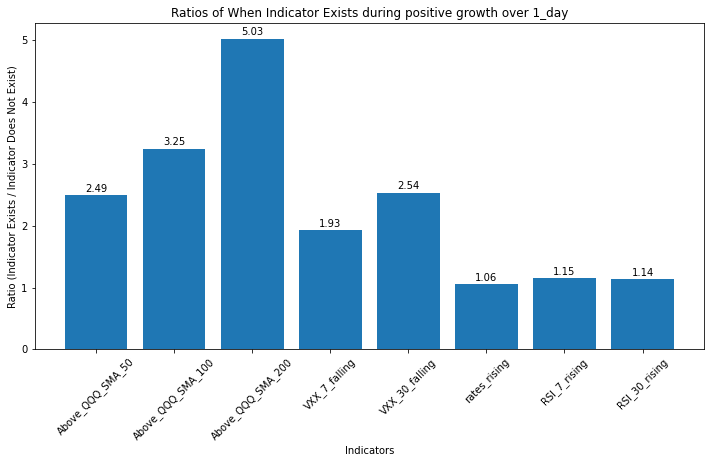

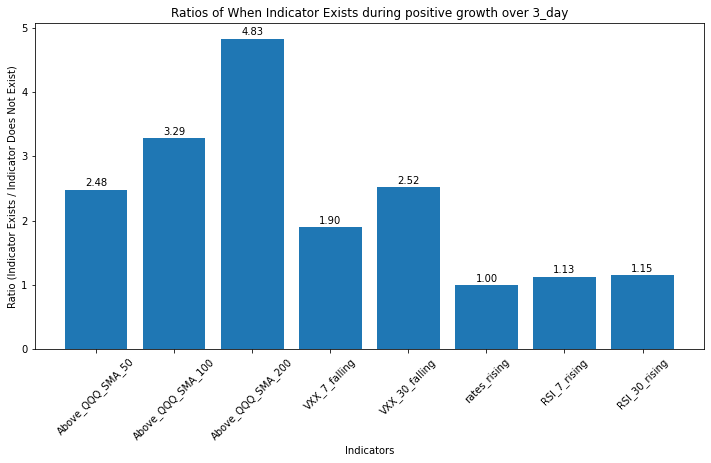

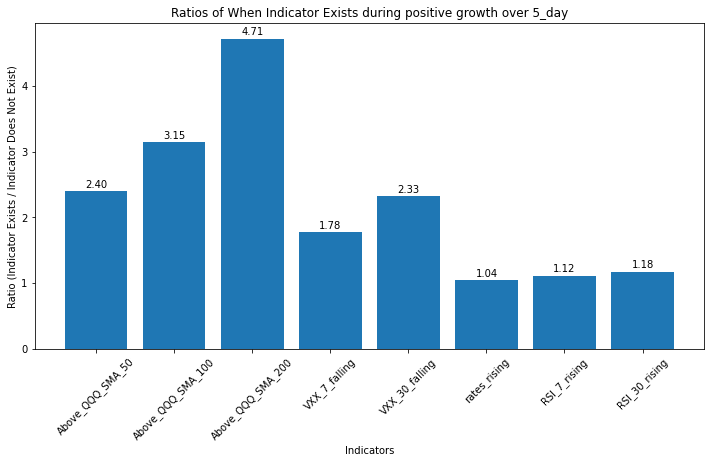

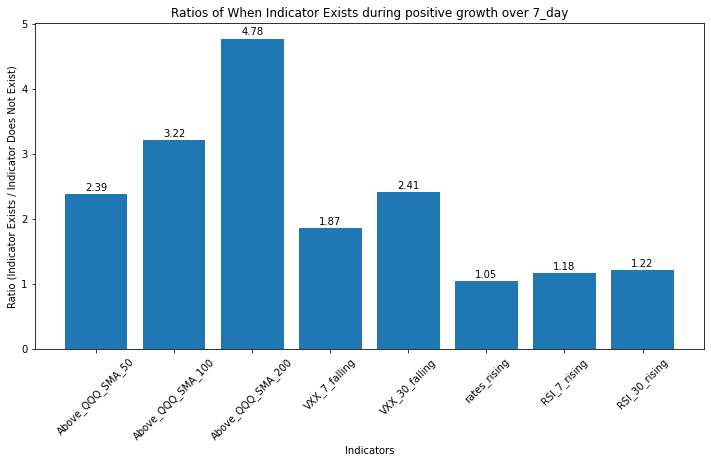

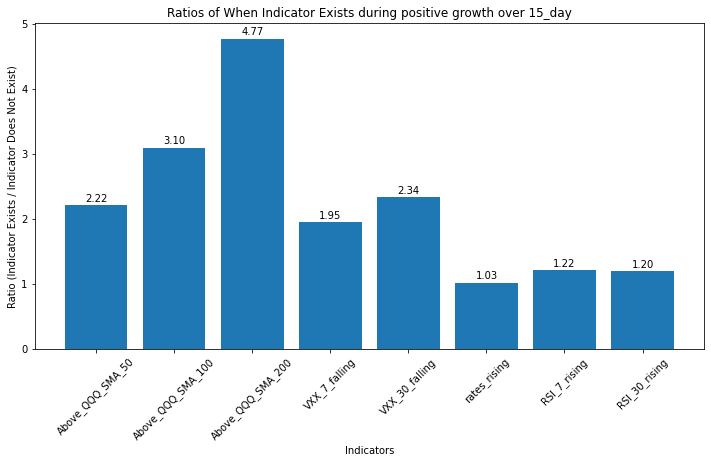

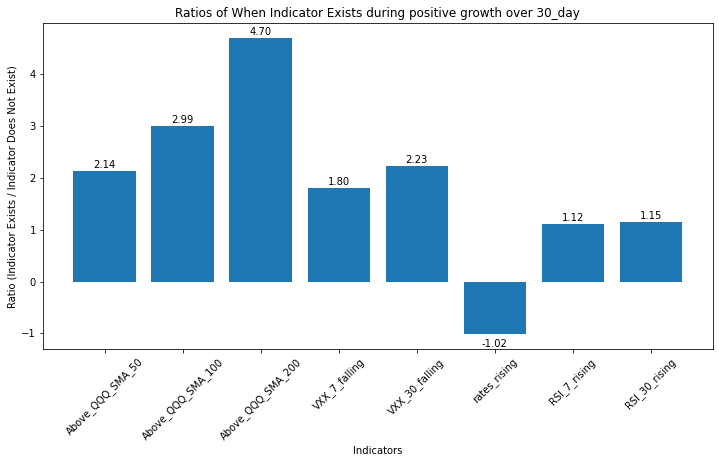

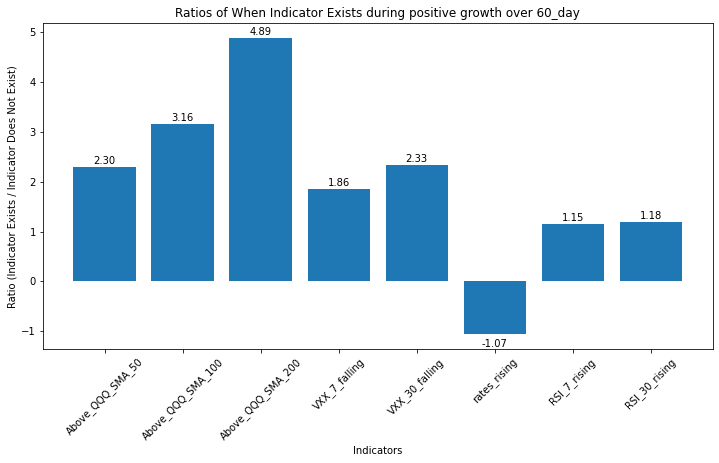

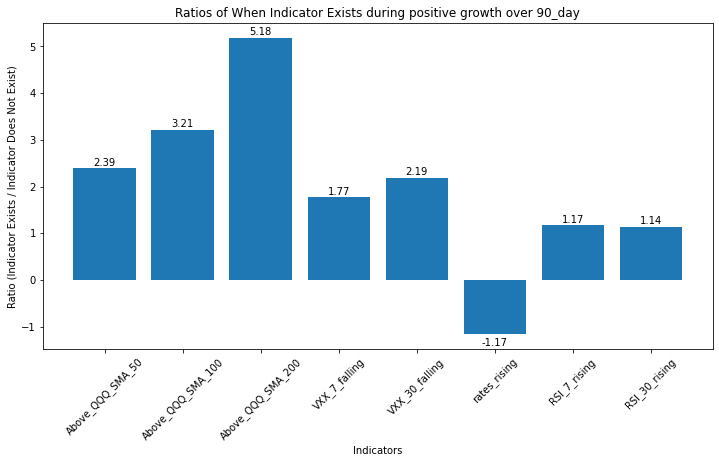

In [43]:
days = ['1_day', '3_day', '5_day', '7_day', '15_day', '30_day', '60_day', '90_day']

#indicators to test
independent_vars = ['Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_falling', 'VXX_30_falling', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']

#iterate through each 'day' time horizon
for day in days:
    #store the ratios in a dict
    ratio_dict = {}
    
    #calc the ratios for each independent variable
    for col in independent_vars:
        #calc the numerator (count when both col and day are 1)
        numerator = ((df_discrete[day] == 1) & (df_discrete[col] == 1)).sum()
        
        #calc the denominator (count when day is 1 and col is 0)
        denominator = ((df_discrete[day] == 1) & (df_discrete[col] == 0)).sum()
        
        #calc the ratio, handling division by zero and ratios below 1
        if denominator != 0:
            ratio = numerator / denominator
            if ratio < 1:
                ratio = -1 / ratio  #calc the negative reciprocal
        else:
            ratio = 0
        
        ratio_dict[col] = ratio

    #extract the values and labels for plotting
    values = list(ratio_dict.values())
    labels = list(ratio_dict.keys())
    
    #create graph, bars and points
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(labels, values)
    points = np.array(values)
    
    #standardize labelling depending on if value is positive or negative
    for label, point in zip(labels, points):
        if point >= 0:
            ax.text(label, point + 0.02, f'{point:.2f}', ha='center', va='bottom')
        else:
            ax.text(label, point - 0.08, f'{point:.2f}', ha='center', va='top')
    
    #finish setting up graph specifics
    ax.set_title(f'Ratios of When Indicator Exists during positive growth over {day}')
    ax.set_xlabel('Indicators')
    ax.set_ylabel('Ratio (Indicator Exists / Indicator Does Not Exist)')
    ax.set_xticks(labels) 
    ax.set_xticklabels(labels, rotation=45)
    
    #plot results
    plt.show()

# Question #1: 
## Are certain indicators more likely to exist when the market is positive than others?
### Answer:
- Yes, as we can see above, for each n_days being analyzed, the 200 day moving average is most frequently true when the market is rising. Additionally, the 100 and 50 day moving averages are most often true as well, but not as frequently. This tells us that the market is most likely to continue rising when it is above its moving averages. Continually, when the VIX is falling consistently over 30 ays, we are most likely to see the market rise over the next n_days and if the RSI value is rising, that also somewhat indicates the market is likely to go up. All of this to say, that yes, certain indicators are more likely to exist when the market is postive over a specific time period

# Machine Learning

In [44]:
price_change = pd.DataFrame()
price_change = df_discrete['30_day']
features = df_discrete[['Above_QQQ_SMA_50', 'Above_QQQ_SMA_100', 'Above_QQQ_SMA_200', 'VXX_7_falling', 'VXX_30_falling', 'rates_rising', 'RSI_7_rising', 'RSI_30_rising']]

In [164]:
#split the data
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    price_change,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2776 samples.
Testing set has 694 samples.


In [165]:
#naive predictor performance
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = np.sum(price_change)/len(price_change)
recall = np.sum(price_change)/(np.sum(price_change) + 0)
precision = np.sum(price_change)/(np.sum(price_change) + (len(price_change) - np.sum(price_change)))
b = 0.5

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+(b**2))*((precision * recall)/((b**2*precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.6813, F-score: 0.7277]


# Question #2: 
## Can we use these indicators to accurately predict market movement over a given time period?
### Answer:
- Yes, as we can see above, we can use these indicators to predict how the market will move over a 30 day period with a decent level of accuracy. Without training the model much, we have an accuracy score of 68% and f-score of 72%, telling us that the model is more likely to predict market movements than pure luck would and it is worth further exploration to continue to improve the model.

In [166]:
#training and predicting pipelines
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size));
    
    # Return the results
    return results

print('Success')

Success


LogisticRegression trained on 2776 samples.
LogisticRegression trained on 277 samples.
LogisticRegression trained on 27 samples.
RandomForestClassifier trained on 2776 samples.
RandomForestClassifier trained on 277 samples.
RandomForestClassifier trained on 27 samples.
GradientBoostingClassifier trained on 2776 samples.
GradientBoostingClassifier trained on 277 samples.
GradientBoostingClassifier trained on 27 samples.


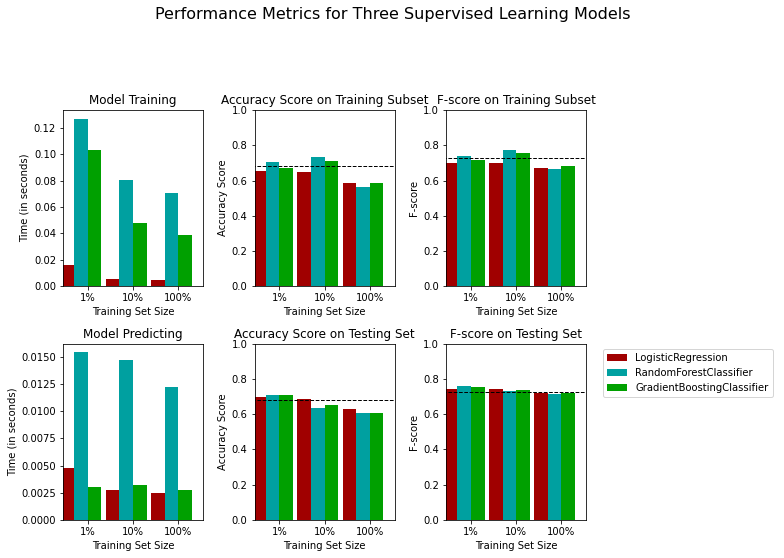

In [167]:
#initial model evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state = 0)
clf_B = RandomForestClassifier(random_state = 0)
clf_C = SVC(random_state = 0)
clf_D = clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100, samples_10, samples_1]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
vs.evaluate(results, accuracy, fscore);

# Top Model Optimization

In [168]:
#Random Forrest Training
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Adding 'None' for default behavior
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.7075
F-score on testing data: 0.7587

Optimized Model
------
Final accuracy score on the testing data: 0.7075
Final F-score on the testing data: 0.7552


In [33]:
#GradientBoostingClassifier Training
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'max_features': ['auto', 'sqrt', 'log2', None],  # Adding 'None' for default behavior
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3645 fits failed out of a total of 14580.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/si

Unoptimized model
------
Accuracy score on testing data: 0.7089
F-score on testing data: 0.7569

Optimized Model
------
Final accuracy score on the testing data: 0.7104
Final F-score on the testing data: 0.7579


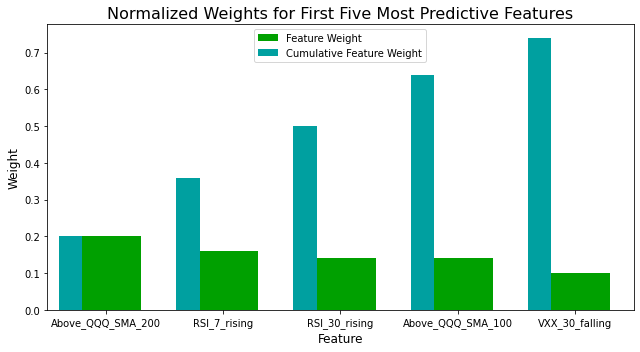

In [169]:
#Extract feature importance
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

# Question #3: 
## Can we improve our model accuracy and get an f-score above 75%? What are the optimal variable weights when we do so?
### Answer:
- Yes, using the models 'GradientBoostingClassifier' or 'RandomForestClassifier', we are able to get an f-score just over 75%. In doing so, we confirm a previous hypothesis that the 200 day SMA is most powerful in predicting future market movements. Followed by that, a rising RSI value over 7 days is next most predictive, followed by a rising RSI over 30 days. These are somewhat correlated so we may want to remove one and focus moreso on the shorter time horizon. Wrapping up, we see that the 100 day moving average is next most predictive and that decreasing volatility comes in 5th, with the top 5 variables explaining just over 70% of the models predictability power.

In [170]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7075
F-score on testing data: 0.7552

Final Model trained on reduced data
------
Accuracy on testing data: 0.6974
F-score on testing data: 0.7423
